In [20]:
import torch

from model.GCN_classifier import TimeDiffClassifier
from model.GCN_classifier import TimeDiffClassifier_sagpooling

import pytorch_lightning as pl

import os.path as osp
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
hparams = {}
hparams['batch_size'] = 32
hparams['num_classes'] = 2
hparams['hidden_channels'] = 64
#hparams['num_node_features'] = 149
hparams['batch_size'] = 32
hparams['lr'] = 1.0e-03
hparams['weight_decay'] = 5.0e-06

s='./data_diff'
hparams['s_data'] = osp.join(*(s.split('/')))
s='./data/DT_File_MAP.xlsx'
hparams['s_node'] = osp.join(*(s.split('/')))
s='./data/[UNC]ADNI-network/dataTS.csv'
hparams['s_date'] = osp.join(*(s.split('/')))
s = './sparsification/data'
hparams['s_sparsified'] = osp.join(*(s.split('/'))) + osp.sep


#model.prepare_data()





cpu


In [4]:
model = TimeDiffClassifier(hparams)
model = model.to(device)

trainer = None

epochs = 300

logdir = './lightning_logs'
network_logger = pl.loggers.TensorBoardLogger(
    save_dir=logdir,
    name='TimeDiffClassify_logs'
)
logger = network_logger

early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
)

In [5]:
trainer = pl.Trainer(max_epochs=epochs, early_stop_callback=early_stopping)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.
C:\Users\rlckd\Anaconda3\envs\graph_matching\lib\site-packages\pytorch_lightning\utilities\distributed.py:23: RuntimeWarning: You have defined a `val_dataloader()` and have defined a `validation_step()`, you may also want to define `validation_epoch_end()` for accumulating stats.
  warnings.warn(*args, **kwargs)

  | Name              | Type           | Params
-------------------------------------------------
0 | model             | GCN            | 22 K  
1 | model.conv1       | GCNConv        | 9 K   
2 | model.conv2       | GCNConv        | 4 K   
3 | model.conv3       | GCNConv        | 4 K   
4 | model.att         | GlobalAtt_gate | 65    
5 | model.att.gate_nn | Linear         | 65    
6 | model.lin1        | Linear         | 4 K   
7 | model.lin2        | Linear         | 130   


Number of training graphs: 103
Number of validation graphs: 12
Number of test graphs: 14


1

In [65]:
model.eval()
_, acc =  model.getTestAcc()
acc

0.7142857142857143

In [6]:
trainer.test(model)

Number of training graphs: 103
Number of validation graphs: 12
Number of test graphs: 14


--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 0.7142857142857143, 'test_loss': tensor(0.3407)}
--------------------------------------------------------------------------------



<BarContainer object of 148 artists>

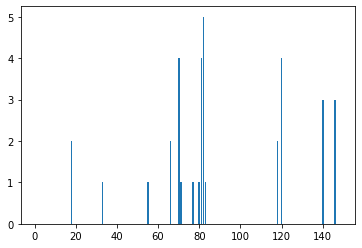

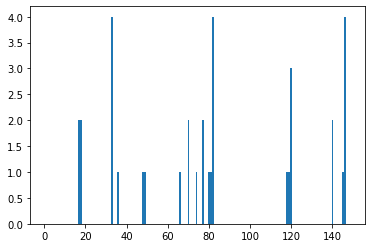

In [58]:
topk = 5
model.model.eval()
cnt_dict = []
cnt_dict.append({i+1:0 for i in range(148)})
cnt_dict.append({i+1:0 for i in range(148)})
for d  in model.dataset['test']:
    #print(d.y)
    att = model.model.get_att(x=d.x, edge_index = d.edge_index, edge_attr = d.edge_attr)
    #att.shape
    att_values = {}
    att_values = {i+1:v[0] for i,v in enumerate(att.tolist())}
    
    #att_values
    l = list({k: v for k, v in sorted(att_values.items(), key=lambda item: item[1], reverse = True)}.keys())
    for tk in l[:topk]:
        cnt_dict[d.y][tk] = cnt_dict[d.y][tk]+1
plt.figure(0)
plt.bar(cnt_dict[0].keys(),cnt_dict[0].values())
plt.figure(1)
plt.bar(cnt_dict[1].keys(),cnt_dict[1].values())

<BarContainer object of 148 artists>

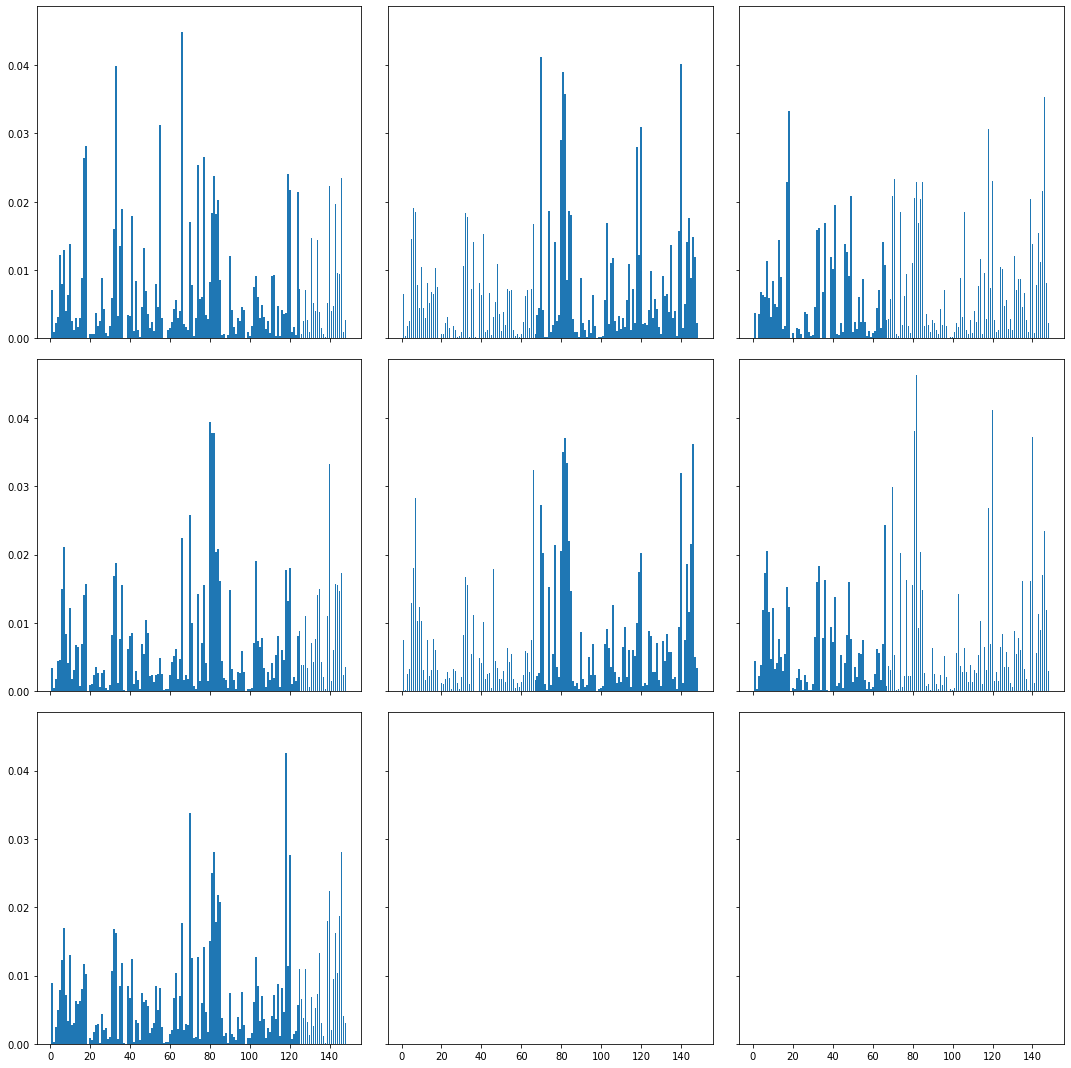

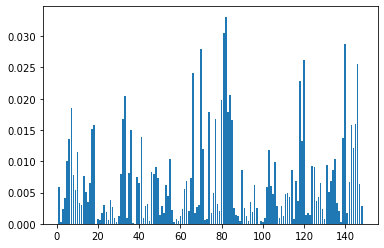

In [87]:
model.model.eval()
nrows = 3
ncols = 3
fig, axes = plt.subplots(figsize=(15, 15) , nrows = nrows, ncols = ncols, sharex='all', sharey='all')
fig.tight_layout()

cnt = 0
avg_dict0 = {i+1:0 for i in range(148)}
for tc,d  in enumerate(model.dataset['test']):
    #print(d.y)
    if(d.y == 0) :
        ax = axes[cnt//ncols][cnt%ncols]
        cnt = cnt+1
        att = model.model.get_att(x=d.x, edge_index = d.edge_index, edge_attr = d.edge_attr)
        #att.shape
        att_values = {}
        att_values = {i+1:v[0] for i,v in enumerate(att.tolist())}
        for j in range(148):
            i=j+1
            avg_dict0[i] = avg_dict0[i] + att_values[i]
        ax.bar(att_values.keys(),att_values.values())

avg_dict0 = {i+1:(avg_dict0[i+1]/cnt) for i in range(148)}
plt.figure(0)
plt.bar(avg_dict0.keys(),avg_dict0.values())

<BarContainer object of 148 artists>

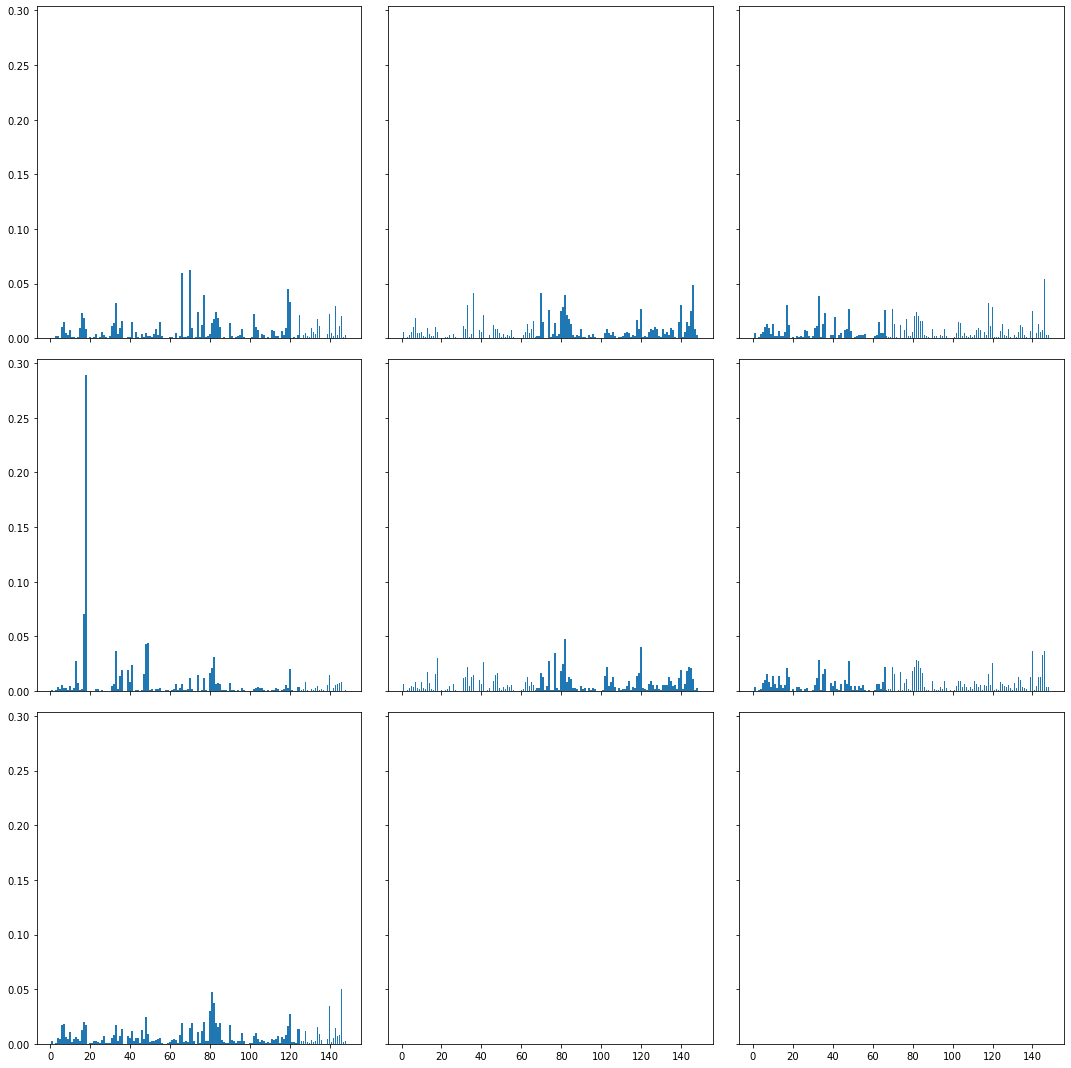

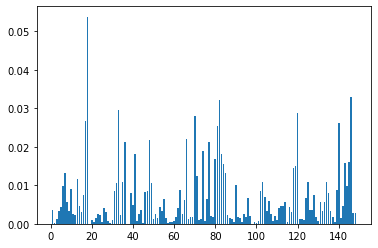

In [93]:
model.model.eval()
nrows = 3
ncols = 3
fig, axes = plt.subplots(figsize=(15, 15) , nrows = nrows, ncols = ncols, sharex='all', sharey='all')
fig.tight_layout()

cnt = 0
avg_dict1 = {i+1:0 for i in range(148)}
for tc,d  in enumerate(model.dataset['test']):
    #print(d.y)
    if(d.y == 1) :
        ax = axes[cnt//ncols][cnt%ncols]
        cnt = cnt+1
        att = model.model.get_att(x=d.x, edge_index = d.edge_index, edge_attr = d.edge_attr)
        #att.shape
        att_values = {}
        att_values = {i+1:v[0] for i,v in enumerate(att.tolist())}
        for j in range(148):
            i=j+1
            avg_dict1[i] = avg_dict1[i] + att_values[i]
        ax.bar(att_values.keys(),att_values.values())

avg_dict1 = {i+1:(avg_dict1[i+1]/cnt) for i in range(148)}
plt.figure(0)
plt.bar(avg_dict1.keys(),avg_dict1.values())

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
hparams = {}
hparams['split_train'] = 0.7
hparams['split_val'] = 0.2


hparams['batch_size'] = 32
hparams['num_classes'] = 2
#hparams['num_classes'] = 3

hparams['hidden_channels'] = 64
hparams['num_node_features'] = 149
hparams['num_layers'] = 6
## 6 --> 2
## 8 --> 3개가 쓰인다.
hparams['ratio'] = 0.8
#hparams['ratio'] = 0.5

hparams['batch_size'] = 32
hparams['lr'] = 3.0e-04
#hparams['lr'] = 5.0e-05

hparams['weight_decay'] = 1.0e-6
#hparams['weight_decay'] = 1.0e-4

#hparams['use_base_edge'] = True
hparams['use_base_edge'] = False


s='./data_diff'
#s='./data_diff_base'
#s='./data_50_diff'
#s='./data_05_diff_base'

hparams['s_data'] = osp.join(*(s.split('/')))
s='./data/DT_File_MAP.xlsx'
hparams['s_node'] = osp.join(*(s.split('/')))
s='./data/[UNC]ADNI-network/dataTS.csv'
hparams['s_date'] = osp.join(*(s.split('/')))
s = './sparsification/data'
#s = './sparsification/data_05'
hparams['s_sparsified'] = osp.join(*(s.split('/'))) + osp.sep

hparams['min_score'] = None
hparams['use_weight'] = True
hparams['nonlinearity'] = torch.sigmoid



cpu


In [24]:
model = TimeDiffClassifier_sagpooling(hparams)
model = model.to(device)

trainer = None

epochs = 300
min_epochs = 10#100

logdir = './lightning_logs'
network_logger = pl.loggers.TensorBoardLogger(
    save_dir=logdir,
    name='TimeDiffClassify_logs'
)
logger = network_logger

early_stopping = pl.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
)
model.model

SAGPool(
  (conv1): GCNConv(149, 64)
  (convs): ModuleList(
    (0): GCNConv(64, 64)
    (1): GCNConv(64, 64)
    (2): GCNConv(64, 64)
    (3): GCNConv(64, 64)
    (4): GCNConv(64, 64)
  )
  (pools): ModuleList(
    (0): SAGPooling(GCNConv, 64, ratio=0.8, multiplier=1)
    (1): SAGPooling(GCNConv, 64, ratio=0.8, multiplier=1)
  )
  (jump): JumpingKnowledge(cat)
  (lin1): Linear(in_features=384, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=2, bias=True)
)

In [25]:
model.model.nonlinearity

<function _VariableFunctionsClass.sigmoid>

In [26]:
model.prepare_data()


Number of training graphs: 90
Number of validation graphs: 25
Number of test graphs: 14


In [ ]:
trainer = pl.Trainer(max_epochs=epochs, early_stop_callback=early_stopping, min_epochs = min_epochs)

trainer.fit(model)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.

   | Name              | Type             | Params
---------------------------------------------------
0  | model             | SAGPool          | 55 K  
1  | model.conv1       | GCNConv          | 9 K   
2  | model.convs       | ModuleList       | 20 K  
3  | model.convs.0     | GCNConv          | 4 K   
4  | model.convs.1     | GCNConv          | 4 K   
5  | model.convs.2     | GCNConv          | 4 K   
6  | model.convs.3     | GCNConv          | 4 K   
7  | model.convs.4     | GCNConv          | 4 K   
8  | model.pools       | ModuleList       | 130   
9  | model.pools.0     | SAGPooling       | 65    
10 | model.pools.0.gnn | GCNConv          | 65    
11 | model.pools.1     | SAGPooling       | 65    
12 | model.pools.1.gnn | GCNConv          | 65    
13 | model.jump        | JumpingKnowledge | 0     
14 | model.lin1        | Linear           | 24 K  
15 | model.lin2        | Linear         

Number of training graphs: 90
Number of validation graphs: 25
Number of test graphs: 14


In [9]:

trainer.test(model)

Number of training graphs: 90
Number of validation graphs: 25
Number of test graphs: 14


--------------------------------------------------------------------------------
TEST RESULTS
{'test_acc': 0.5, 'test_loss': tensor(0.7446)}
--------------------------------------------------------------------------------



In [10]:
hparams['ratio']**((hparams['num_layers']-1)/2)

0.5724334022399462

In [11]:
0.8**3*148

75.77600000000002

In [12]:
148*0.8

118.4

In [77]:
model.dataset['test']

~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tensor([1])
-----node-----
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tensor([ 72,   0,  15,  43, 146,  44,  96,  48,  23,  40,  97,  64,  55,   1,
         47,  56,  33,  67, 114, 115,  79,  51,  58,   7,  22,  92,  66,  60,
        110, 139,  25,  13,  18,  21, 145, 125, 117, 108,  36, 123, 134,  71,
         24,  89,  37, 129,   3,  12,  99,  73, 118, 121, 138,  57, 107,  75,
          2,  50,  46, 127,  41, 122,  19,  87,  28,  20,  63,  49, 131,  35,
         74,  14,  65, 109,  53,  68, 136, 120,  16,  45,  62, 119,  81,  95,
         29,  88,  94,  59,  90, 126, 141,  32, 133, 103,  42,  77,   5,  34,
         27, 143,  84, 135,  17,  11, 116,  85, 111,  31,  39,  30,  26, 105,
        102,  69,  80,  91,  98, 140, 100])
tensor([0.3442, 0.3367, 0.3196, 0.3173, 0.3152, 0.3087, 0.3083, 0.3080, 0.3024,
        0.2957, 0.2913, 0.2904, 0.2867, 0.2865, 0.2863, 0.2851, 0.2834, 0.2828,
        0.2821, 0.2793, 0.2771, 0.2733, 0.2732, 0.2724, 0.2700, 0.2692, 0.2681,
       

        145,  41,  42,  19, 141,  66,  27,  50,  54,  98,   1,  21])
tensor([], dtype=torch.int64)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tensor([1])
-----node-----
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tensor([ 26,  89,  15,  21, 139,  18,  33, 107, 103, 111,  11,  93, 100,  65,
         88,  29,  87,  20,  97,  37,  95,  25,  28,  24,  19,  92,   1,  34,
         99,  96,  23, 116,  98,  14,  94, 117,  42,  75, 115,  41,  85,  43,
        108, 102,  84, 121,  40,  78,  55,  13,  10,  83,  48,  35,  74,   3,
        110, 129,  36, 114,  91,  82,   2,  79,  12,  76,  16,   9, 120,  22,
         58,  77, 138, 136,  27,  64, 122,  60,  72, 119,  17, 133,  49,  47,
          5, 132, 146, 134,  71,  59, 109,  90,   8, 105,  38, 124,  30, 104,
        125, 123,   4,  32, 147,  45, 106,  80,  31,  50,   6,  57, 130,  62,
        101,   0,  66,  67,  51,  61, 135])
tensor([0.3910, 0.3501, 0.3371, 0.3202, 0.3035, 0.2999, 0.2944, 0.2939, 0.2915,
        0.2847, 0.2841, 0.2828, 0.2823, 0.2773, 0.2747, 0.2724, 0.27

-----node-----
@@@@@@@@@@@@@@@@@@@@@@@@@@@@
tensor([ 15,  89, 103,  25, 139,  96, 146,  29,  18,  40,  97,  76,  33,  88,
        114,  60,  79, 116,  26,  72,  42, 100,  48,  99,  20,  11, 122,  17,
         94,  21,  64,  51,  71,  55,  91, 134,   3,  37,  92,  74,  24,  19,
         98, 107,  65,  93, 138, 115,  22,  41,  57,  28,  95,  59,  43, 125,
         77,  36,  14, 117,  58,  23,   2, 102,  56,   1,  75,  67, 121, 105,
         66, 108, 111,  13,  10,   0, 129, 104,  47, 136, 120, 123, 132, 110,
         87, 131,  85,   4,   7, 135,   9,  86, 130,  83,  34,  32,  16,  44,
        118, 145,  80,  62, 133,  90, 140,  82, 144, 141,  84, 127,  68,  27,
         50, 106,  31,  81,   8, 124,  35])
tensor([0.3570, 0.3513, 0.3319, 0.3301, 0.3177, 0.3110, 0.3070, 0.3036, 0.3026,
        0.3021, 0.3018, 0.2966, 0.2956, 0.2953, 0.2939, 0.2904, 0.2903, 0.2888,
        0.2887, 0.2799, 0.2778, 0.2766, 0.2763, 0.2728, 0.2714, 0.2711, 0.2697,
        0.2690, 0.2670, 0.2649, 0.2647, 0.2610, 

dict_keys([])


<BarContainer object of 148 artists>

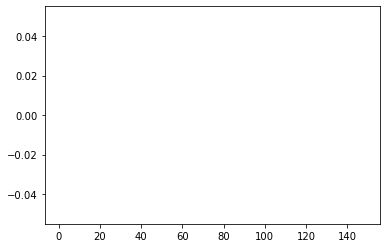

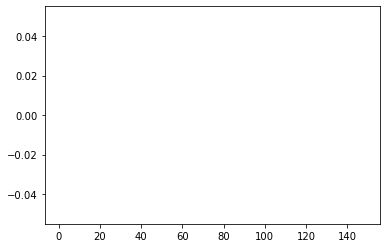

In [13]:
from torch_geometric.data import DataLoader



cnt_dict = []
cnt_dict.append({i+1:0 for i in range(148)})
cnt_dict.append({i+1:0 for i in range(148)})

for tc,d  in enumerate(DataLoader(model.dataset['test'], batch_size = 1)):
        
    
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

    #if(d.y == 0) : continue
    
    print(d.y)
    node = torch.tensor(range(1,149))
    ps,ss = model.model.get_att(d)
    #print(ps[0].shape, ps[1].shape, ps[2].shape)
    len_ps = len(ps)
    #print(len_ps)
    
    print('-----node-----')
    #node = node[ps[0]]
    #node = node[ps[1]]
    #node = node[ps[2]]
    for i in range(len_ps):
        node = node[ps[i]]
        print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
        print(ps[i])
        print(ss[i])
        
    
    print(node)
    #print(ss[-1])
    #print(ss[-2])
    
    
    print(node[(ss[-1]>0.5)])
    for v in node[(ss[-1]>0.5)].tolist():
        cnt_dict[d.y][v] =  cnt_dict[d.y][v] + 1
    
    
    #if(tc >= 5): break
plt.figure(0)
print(dict(filter(lambda elem:elem[1]>=5, cnt_dict[0].items())).keys())
plt.bar(cnt_dict[0].keys(),cnt_dict[0].values())


plt.figure(1)
print(dict(filter(lambda elem:elem[1]>=6, cnt_dict[1].items())).keys())
plt.bar(cnt_dict[1].keys(),cnt_dict[1].values())



In [17]:
model.model.pools[0].nonlinearity

<function _VariableFunctionsClass.tanh>

In [32]:
[ss_.shape for ss_ in ss]

[torch.Size([119]), torch.Size([96]), torch.Size([77])]

In [90]:
node = torch.tensor(range(148))
no

In [78]:

[ 6,  2,  8, 22, 18, 13,  9, 23, 11,  7,  5, 12]
[35, 20, 77, 19,  0, 15, 50, 26,  5, 17, 81, 28, 22, 24, 75,  9, 69, 36,
        11, 14, 16, 79, 47, 56,  6, 52, 94,  8,  1,  7, 45]

[6, 2, 8, 22, 18, 13, 9, 23, 11, 7, 5, 12]